# Imports

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec, lines, legend_handler
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.stats as scs
from statsmodels.formula.api import ols
from os import path
from IPython.display import display


from python_scripts.utils import loc_utils as lut
from python_scripts.utils import vis_utils as vut
from python_scripts.utils.vis_utils import gcolors, glabels, fullglabels, gmarkers, colors, ncolors, tlabels

# Figure 1b

In [ ]:
def make_fig1b(data_path, figname, save_to='LOCAL', save_as=''):
    cols = ['sid', 'grp', 'tid', 'pc_first']
    df = lut.unpickle(data_path)
    df = df.loc[:, cols]
    df = df.replace({'1_1D': 1, '2_I1D': 2, '3_2D': 3, '4_R': 4, 'F': 0, 'S': 1})
    df['percent_correct'] = df.pc_first * 100

    fig = plt.figure(figname, figsize=[5, 5])

    ax = vut.pretty(fig.add_subplot(111))
    palet = sns.set_palette(sns.color_palette(gcolors))
    sns.boxplot(x='tid', y='percent_correct', hue='grp', data=df,
                saturation=1, palette=palet, ax=ax)

    props = {'connectionstyle': 'bar',
             'arrowstyle': '-',
             'patchA': None, 'patchB': None,
             'shrinkA': 10, 'shrinkB': 10,
             'linewidth': 2}
    bh, pad = 100, .025
    for i in range(3):
        ax.text(x=i + .5, y=bh + 15, s='***', fontsize=15, ha='center', va='top')
        ax.annotate('', xy=(i + pad, bh), xytext=(i + 1 - pad, bh), xycoords='data',
                    ha='center', va='top', arrowprops=props)

    ax.set_ylim(0, 115)
    ax.set_xlim(-.5, 3.8)
    ax.set_xlabel('Learning activity', fontsize=15)
    ax.set_ylabel('% correct', fontsize=20)
    ax.set_xticklabels(['A1', 'A2', 'A3', 'A4'], fontsize=15, fontweight='bold')
    for xt, c in zip(ax.get_xticklabels(), colors):
        xt.set_color(c)

    ax.legend_.remove()
    ax.text(3.5, 100, glabels[0], va='top', ha='left',
            fontsize=15, fontweight='bold', color=gcolors[0])
    ax.text(3.5, 80, glabels[1], va='bottom', ha='left',
            fontsize=15, fontweight='bold', color=gcolors[1])

    fig.tight_layout()
    if save_as:
        vut.save_it(fig, save_to, figname, save_as=save_as)


make_fig1b(
    data_path='data/long3.pkl',
    figname='figure1b',
    save_to='figures',
    save_as='' # File format (png, jpeg, svg, ...)
)


# Figure 2a

In [ ]:
def make_fig2a(data_path, figname, save_to, save_as=None):
    # Load data
    df = pd.read_csv(data_path)[['sid','group','trial','activity']]
    
    # Select only required free-play trials (N = 250)
    df = df.loc[df.trial <= 60+250].drop(columns='trial')
    
    # Count trials per activity for each subject
    counts = df.groupby(['group', 'sid']).activity.value_counts().to_frame('counts')
    counts = ((counts - 15)/250)*100
    counts_stats = counts.groupby(['group','activity']).agg(['mean', 'sem'])
    counts_stats.columns = counts_stats.columns.droplevel(0)
    display(counts_stats)

    fig = plt.figure(figname, figsize=[5, 4])
    ax = vut.pretty(fig.add_subplot(111), 'y')
    ax.axhline(25, ls='--', color='k', alpha=.8)
    x = np.array([1, 2, 3, 4])
    for i, grp in enumerate([1, 0]):
        y = counts_stats.loc[(grp, slice(None)), 'mean']
        yerr = counts_stats.loc[(grp, slice(None)), 'sem']
        ax.errorbar(x, y, yerr=yerr, color=gcolors[grp], marker=gmarkers[grp],
                    capsize=5, markersize=8, lw=2, label=fullglabels[grp])

    ax.set_xticks(x)
    ax.set_xticklabels(['A1', 'A2', 'A3', 'A4'], fontsize=14, fontweight='bold')
    for xt, c in zip(ax.get_xticklabels(), colors):
        xt.set_color(c)

    ax.set_xlabel('Learning activity', fontsize=14)
    ax.set_ylabel('Trials per activity\n(%; Mean and SEM)', fontsize=14)
    leg = ax.legend(fontsize=14)

    fig.tight_layout()
    if save_as:
        vut.save_it(fig, save_to, figname, save_as=save_as, compress=False)


make_fig2a(
    data_path='data/clean_data.csv',
    figname='figure2a',
    save_to='figures',
    save_as='' # File format (png, jpeg, svg, ...)
)

# Figure 2b

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                correct   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.487
Method:                 Least Squares   F-statistic:                     159.1
Date:                Sun, 15 Nov 2020   Prob (F-statistic):           3.05e-72
Time:                        02:44:05   Log-Likelihood:                -1347.8
No. Observations:                 500   AIC:                             2704.
Df Residuals:                     496   BIC:                             2720.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                      65.3227      0.457    143.062      0.000      64.426      66.220
C(group, Treatment(reference=1))[T.0]           2.9381      0.646      4.550      0.000       1.669       4.207
trial                                          -0.0021      0.003     -0.655      0.513      -0.008       0.004
trial:C(group, Treatment(reference=1))[T.0]     0.0284      0.004      6.358      0.000       0.020       0.037
==============================================================================
Omnibus:                        0.151   Durbin-Watson:                   1.734
Prob(Omnibus):                  0.927   Jarque-Bera (JB):                0.191
Skew:                          -0.041   Prob(JB):                        0.909
Kurtosis:                       2.952   Cond. No.                         760.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

group 0: Y = 65.323 - 0.002*X
group 1: Y = 68.261 + 0.026*X


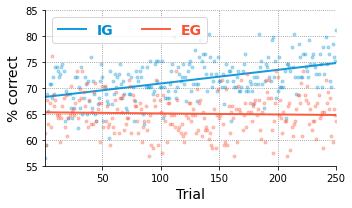

In [76]:
def make_top_fig(data_path, figname, save_to, save_as=None):
    # Load data, select columns
    df = pd.read_csv(data_path)[['sid','group','trial','activity']]
    
    # Select free-play trials
    df = df.loc[(df.trial <= 60+250) & (df.trial > 60)]
    df.loc[:, 'trial'] -= 60
    
    # Get group sizes
    group_sizes = [group_sids.size for group_sids in df.groupby(['group']).sid.unique().values]
    
    # Count subjects per activity per trial for each group
    df = df.groupby(['group','activity','trial']).agg({'sid': 'nunique'})
    df = df.rename(columns={'sid':'n'})

    # Create figure, define gridspec
    fig = plt.figure(figname, figsize=[5, 6])
    gs = gridspec.GridSpec(2, 1)

    # Create ghost axis for common label
    ax = fig.add_subplot(gs[:2, 0])
    ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set_ylabel('Fraction of Ps selecting a learning activity', fontsize=14, labelpad=30)

    for i, grp in enumerate([1, 0]):
        ax = vut.pretty(fig.add_subplot(gs[i, :3]))
        ax.set_xlim(1, 250)
        ax.set_ylim(.08, .5)
        ax.grid(True)

        if i:
            ax.set_xlabel('Trial', fontsize=14)
        else:
            ax.tick_params(labelbottom=False)
            handles = [lines.Line2D([0], [0], color=colors[k], ls='', marker='o', label=tlabels[k + 1]) for k in range(4)]
            leg = ax.legend(handles, tlabels.values(), handletextpad=.05,
                            bbox_to_anchor=(0, 1, 1, 0.2), loc='lower left', mode='expand', ncol=4, fontsize=14)
            vut.color_legend(leg)

        txt = ax.text(x=.05, y=.95, s=fullglabels[grp],
                      ha='left', va='top', transform=ax.transAxes,
                      color=gcolors[grp], fontweight='bold', fontsize=14)

        for j, activity in enumerate(df.index.unique(1).tolist()):
            psel = df.loc[(grp, activity, slice(None)), 'n'].sort_index().values / group_sizes[grp]
            ax.plot(psel, c=colors[j], label=activity, lw=2)

    fig.tight_layout()
    if save_as:
        vut.save_it(fig, save_to, figname, save_as=save_as, compress=False)


def make_bottom_fig(data_path, figname, save_to, save_as=None):
    # Load data, select columns
    df = pd.read_csv(data_path)[['sid','group','trial','correct']]
    
    # Select free-play trials
    df = df.loc[(df.trial <= 60+250) & (df.trial > 60)]
    df.loc[:, 'trial'] -= 60
    
    # Calculate percentage of subjects who guessed correctly for each trial in each group
    df = df.groupby(['group', 'trial'])[['correct']].mean()
    df.loc[:, 'correct'] = df.correct * 100
    
    # Fit linear regression (set EG for contrast reference)
    lm = ols('correct ~ trial*C(group,Treatment(reference=1))', data=df.reset_index()).fit()
    params = lm.params
    display(lm.summary())

    # Make figure
    fig = plt.figure(figname, figsize=[5, 3])
    ax = vut.pretty(fig.add_subplot(111))

    for grp in [0, 1]:
        # Display raw percentages
        x = np.arange(1, 251)
        y = df.loc[(grp, slice(None)), :].values.squeeze()
        ax.plot(x, y, color=gcolors[grp], ls='', alpha=.3, marker='.')
        
        # Display model predictions 
        x_ = np.array([1, 251])
        y_ = lm.predict({'group': (grp, grp), 'trial': x_})
        ax.plot(x_, y_, color=gcolors[grp], lw=2, alpha=.9, label=fullglabels[grp])
        
        # Print fitted line equations
        intercept = params[0] + params[1] * grp
        slope = params[2] + params[3] * grp
        pos = int(slope > 0)
        txt = 'Y = {:.3f} {} {:.3f}*X'.format(intercept, '-+'[pos], np.abs(slope))
        print('group {}: {}'.format(grp, txt))

    ax.set_xlabel('Trial', fontsize=14)
    ax.set_ylabel('% correct', fontsize=14)

    leg = ax.legend(fontsize=14, ncol=2)
    vut.color_legend(leg)

    ax.set_ylim(55, 85)
    ax.set_xlim(1, 250)
    fig.tight_layout()

    if save_as:
        vut.save_it(fig, save_to, figname, save_as=save_as, compress=False)


data_path = 'data/clean_data.csv'
save_path = 'figures'
fig_format = '' # File format (png, jpeg, svg, ...)

make_top_fig(
    data_path=data_path,
    figname='figure2b_top',
    save_to=save_path,
    save_as=fig_format
)

make_bottom_fig(
    data_path=data_path,
    figname='figure2b_bottom',
    save_to=save_path,
    save_as=fig_format
)

# Figure 2c 

Figure 2c was prepared in R.  The figure can be reproduced by running an R script stored in *R_scripts/figure2c.R*

# Figure 3

In [ ]:
def make_fig(data_path, figname, save_to, save_as=''):
    xstr = 'sc_lep'
    df = lut.unpickle(data_path).sort_values(by=xstr)
    df = df.loc[df.ntm > 0, :]

    propS = np.sum(df.grp == 1) / df.shape[0]

    fig = plt.figure(figname, figsize=[7, 7])
    gs = gridspec.GridSpec(2, 2)

    # Figure (scatter plot and histograms)
    # ====================================
    ghost_top = fig.add_subplot(gs[0, 0])
    ghost_top.set_ylabel('Relative frequency', fontsize=14, labelpad=30)
    ghost_top.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
    for spine in ghost_top.spines.values(): spine.set_visible(False)

    ax_top1 = vut.pretty(inset_axes(ghost_top, width='100%', height='30%', loc=9, borderpad=0))
    ax_top2 = vut.pretty(inset_axes(ghost_top, width='100%', height='30%', loc=10, borderpad=0))
    ax_top3 = vut.pretty(inset_axes(ghost_top, width='100%', height='30%', loc=8, borderpad=0))

    ghost_right = fig.add_subplot(gs[1, 1])
    ghost_right.set_xlabel('Relative frequency', fontsize=14, labelpad=30)
    ghost_right.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
    for spine in ghost_right.spines.values(): spine.set_visible(False)
    ax_right1 = vut.pretty(inset_axes(ghost_right, width='30%', height='100%', loc=6, borderpad=0))
    ax_right2 = vut.pretty(inset_axes(ghost_right, width='30%', height='100%', loc=10, borderpad=0))
    ax_right3 = vut.pretty(inset_axes(ghost_right, width='30%', height='100%', loc=7, borderpad=0))

    ax_scat = vut.pretty(fig.add_subplot(gs[1, 0]))

    bins = np.arange(0, 1.02, .1)
    labels = {'ntm': ['NAM ' + str(i) for i in (0, 1, 2, 3)], 'grp': fullglabels}
    axes_by_ntm = {
        'top': {
            3: ax_top1,
            2: ax_top2,
            1: ax_top3},
        'right': {
            1: ax_right1,
            2: ax_right2,
            3: ax_right3}}
    for ntm in [1, 2, 3]:
        axes_by_ntm['top'][ntm].set_xlim(.0, .8)
        axes_by_ntm['top'][ntm].set_ylim(0., .4)
        axes_by_ntm['right'][ntm].set_xlim(0., .45)
        axes_by_ntm['right'][ntm].set_ylim(0.38, 1.)
        for grp in [0, 1]:
            x = df.loc[(df.ntm == ntm) & (df.grp == grp), xstr]
            y = df.loc[(df.ntm == ntm) & (df.grp == grp), 'post']
            ax_scat.scatter(x, y, s=30, alpha=.7,
                            facecolors=ncolors[ntm - 1] if grp else 'w',
                            edgecolors=ncolors[ntm - 1])

            rf, _ = np.histogram(x, bins=bins, weights=np.ones_like(x) / x.size)
            axes_by_ntm['top'][ntm].plot(bins[:-1], rf, c=ncolors[ntm - 1], lw=2,
                                         ls='-' if grp else '--',
                                         label='{} / NAM-{}'.format(glabels[grp], ntm))
            axes_by_ntm['top'][ntm].tick_params(labelbottom=False)
            axes_by_ntm['top'][ntm].text(.02, .9, 'NAM-{}'.format(ntm), ha='left', va='top', fontsize=12,
                                         color=ncolors[ntm - 1], transform=axes_by_ntm['top'][ntm].transAxes)

            rf, _ = np.histogram(y, bins=bins, weights=np.ones_like(x) / x.size)
            axes_by_ntm['right'][ntm].plot(rf, bins[1:], c=ncolors[ntm - 1], lw=2,
                                           ls='-' if grp else '--',
                                           label='{} / NAM-{}'.format(glabels[grp], ntm))
            axes_by_ntm['right'][ntm].tick_params(labelleft=False)
            axes_by_ntm['right'][ntm].text(.95, .02, 'NAM-{}'.format(ntm), ha='right', va='bottom', fontsize=12,
                                           color=ncolors[ntm - 1], transform=axes_by_ntm['right'][ntm].transAxes)

    ax_scat.set_xlim(.0, .8)
    ax_scat.set_ylim(0.38, 1.)
    ax_scat.set_xlabel('Self-challenge (SC)', fontsize=14)
    ax_scat.set_ylabel('Weighted performance (dwfPC)', fontsize=14)

    # Edit legend
    c = 'darkgray'
    mark_ig = lines.Line2D([0], [0], ls='', marker='o', label=fullglabels[0], markerfacecolor='w', markeredgecolor=c)
    line_ig = lines.Line2D([0], [0], color=c, lw=2, label=fullglabels[0], ls='--', dashes=(2, 1))

    mark_eg = lines.Line2D([0], [0], color=c, ls='', marker='o', label=fullglabels[1])
    line_eg = lines.Line2D([0], [0], color=c, lw=2, label=fullglabels[1])

    ax_scat.legend(((line_ig, mark_ig), (line_eg, mark_eg)), fullglabels.values(),
                   bbox_to_anchor=(.5, 1.1,),
                   fontsize=12, ncol=3, loc='center',
                   handler_map={tuple: legend_handler.HandlerTuple(ndivide=None)})

    # Main Model
    # ====================================
    qreg = ols('post ~ (pre + {0} + np.power({0}, 2) + grp)'.format(xstr), data=df).fit()
    x = np.linspace(df.loc[:, xstr].min(), df.loc[:, xstr].max(), 100)
    y_hat = qreg.get_prediction({xstr: x,
                                 'pre': np.full_like(x, df.pre.mean()),
                                 'grp': np.full_like(x, propS)
                                 }).summary_frame()
    display(y_hat.head())
    c, alpha = 'k', .7
    ax_scat.plot(x, y_hat['mean'], c=c, alpha=alpha)
    ax_scat.plot(x, y_hat['mean_ci_lower'], c=c, lw=1, ls='--', alpha=alpha)
    ax_scat.plot(x, y_hat['mean_ci_upper'], c=c, lw=1, ls='--', alpha=alpha)

    df.loc[:, xstr] = scs.stats.zscore(df.loc[:, xstr]) # Standardize x before fitting the quadratic model
    
    # Run quadratic regression of final performance
    qreg = ols('post ~ (pre + {0} + np.power({0}, 2) + grp)'.format(xstr), data=df).fit()
    display(qreg.summary())
    
    # Run nonquadratic regression and compare AIC
    nonqreg = ols('post ~ (pre + {0} + grp)'.format(xstr), data=df).fit()
    print('Delta AIC = {:.2f}'.format(qreg.aic - nonqreg.aic))

    # Run model of average SC as a function of Group x NAM
    lreg = ols('{} ~ C(grp) * C(ntm)'.format(xstr), data=df).fit()
    display(lreg.summary())
    
    # Show group and subgroup counts
    display(df.groupby(['grp', 'ntm'])['sid'].agg('count'))
    
    # Save figure
    fig.tight_layout()
    if save_as:
        vut.save_it(fig, save_to, figname=figname, save_as=save_as, compress=False, dpi=100)


make_fig(
    data_path='data/lpreds_data.pkl',
    figname='figure3',
    save_to='figures',
    save_as='' # File format (png, jpeg, svg, ...)
)

# Figure 4a

In [ ]:
def make_fig(data_path, figname, save_to, save_as=''):
    baseline = 693.1471805599454
    ic = 'aic'
    df = pd.read_csv(data_path)
    fdf = pd.read_csv(data_path)[['form', 'loss', ic]]
    fdf['nvars'] = 6 - df.loc[:, 'tau':'relt_coef'].isnull().sum(axis=1)
    fdf.loc[:, ic] = 2 * fdf.loss + 2 * fdf.nvars
    fdf = fdf[~fdf.form.str.contains('dLP')]
    fdf = fdf[~fdf.form.str.contains('mLP')]
    fdf = fdf[~fdf.form.str.contains('RELT')]
    fdf.replace(['rLP', 'PC + rLP'], ['LP', 'PC + LP'], inplace=True)
    byform = fdf.set_index('form')

    fdf = fdf.loc[:, ('form', 'aic')].groupby(['form']).agg(['mean', 'std'])
    fdf = fdf.sort_values(by=(ic, 'mean'), ascending=True)
    display(fdf)

    fig = plt.figure(figname, figsize=(5, 3.5))
    ax = vut.pretty(fig.add_subplot(111), 'x')

    fdf = fdf.sort_values(by=(ic, 'mean'), ascending=False)
    sns.violinplot(x=ic, y='form', data=byform.reset_index(), ax=ax,
                   color='lightgray', linewidth=1.5, order=fdf.index)
    for v in ax.collections: v.set_edgecolor('w')

    ax.axvline(baseline, ls='--', zorder=3, color='red',
               label='Random model')
    ax.set_ylabel('Model', fontsize=14)
    ax.set_xlabel('AIC', fontsize=14)
    ax.set_xlim([200, 800])
    ax.legend()

    print('Baseline AIC = {}'.format(baseline))
    fig.tight_layout()
    if save_as:
        vut.save_it(fig, save_to, figname=figname, save_as=save_as, compress=False, dpi=100)


make_fig(
    data_path='data/choiceModelComparison_PC_dLP_rLP_mLP_RELT_300seeds.csv',
    figname='figure4a',
    save_to='figures',
    save_as='' # File format (png, jpeg, svg, ...)
)

# Figure 4b

Figure 4b was prepared in R. The figure can be reproduced by running an R script stored in *R_scripts/figure4b.R*